In [1]:
# Import all neccessary libraries
# table data handling
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# multiobjective optimization related
from pymoo.util.nds.fast_non_dominated_sort import fast_non_dominated_sort as ndsort
from pymoo.factory import get_performance_indicator
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import utils
# others
from tqdm import tqdm

In [2]:
sns.set_theme(style="white", palette="bright")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

## Read Data

In [3]:
# Read data of ts2n problem
method_file_names = ['Lex-DE', 'NSGA-II', 'RVEA']
method_names = ['Lex-DE', 'NSGA-II', 'RVEA']
reps = [1,2,3,4,5]

objective_sim_names = [f'fit_{i}' for i in range(5)]
objective_cod_names = ['FOPT', 'FWPT', 'FOPR', 'FWPR', 'FGPR']

parameter_names = [
    'POROSITY', 'WOC', 'COMPRESS',
    'PERMXL1', 'PERMXL2', 'PERMXL3', 'PERMXL4', 'PERMXL5',
    'PERMZL1', 'PERMZL2', 'PERMZL3', 'PERMZL4', 'PERMZL5'
]

In [4]:
ts2n_hdfs = []
for i, method_file_name in tqdm(enumerate(method_file_names)):
    for j, rep in enumerate(reps):
        tmp = pd.read_hdf(f'ts2n/{method_file_name}{rep}.hdf5').sort_values(['eval'], ignore_index=True)
        tmp['Method'] = method_names[i] # specify the method
        tmp['Repetition'] = j           # specify the repetition
        tmp_obj_val = tmp[objective_sim_names].values
        nd_idx = ndsort(tmp_obj_val)[0]
        is_nd = np.array([False]*len(tmp))
        is_nd[nd_idx] = True
        tmp['is_nd'] = list(is_nd)      # specify whether the individual is non-dominated
        ts2n_hdfs.append(tmp)
ts2n_dat = pd.concat(ts2n_hdfs).sort_values(['Method','Repetition','eval'])
ts2n_dat.head(3)

3it [00:29,  9.80s/it]


,eval,gen,ind,POROSITY,WOC,COMPRESS,PERMXL1,PERMXL2,PERMXL3,PERMXL4,...,FOPT,FOPR,fit_0,fit_1,fit_2,fit_3,fit_4,Method,Repetition,is_nd
0,1.0,1.0,0.0,0.329662,4903.930894,0.000087,201.487264,433.164972,394.243378,129.760609,...,207535.587073,202.785435,207535.587073,142495.219915,202.785435,264.002974,131.857877,Lex-DE,0,False
1,2.0,1.0,1.0,0.370714,4881.605625,0.000083,203.508600,444.164973,373.246040,103.508060,...,95440.579512,93.256142,95440.579512,65530.097449,93.256142,121.408448,60.638199,Lex-DE,0,False
2,3.0,1.0,2.0,0.350213,4917.577726,0.000082,206.777737,364.627371,417.191602,88.310015,...,247530.886341,241.864976,247530.886341,169956.108156,241.864976,314.880051,157.268769,Lex-DE,0,False


## Preprocessing

1. scale the five objective values into $[0,1]$ based on all individuals
2. scale the five objective values into $[0,1]$ based on non-dominated individuals
3. scale the 13 parameter values into $[0,1]$ based on all individuals

In [5]:
# Scale the objective values and parameter values between 0 and 1
scaler = MinMaxScaler()

# scale by all individuals in 3 methods x 5 repetitions x 1500 evaluations
ts2n_fit_scaled_by_all = scaler.fit_transform(ts2n_dat[objective_sim_names].to_numpy())
ts2n_fit_scaled_by_all = pd.DataFrame(ts2n_fit_scaled_by_all, columns=[f'{item}_scaled_by_all' for item in objective_sim_names])

# scale by all individuals in 3 methods x 5 repetitions x number of non-dominated individuals
ts2n_fit_scaled_by_nd = scaler.fit(ts2n_dat[ts2n_dat.is_nd][objective_sim_names].to_numpy()).transform(ts2n_dat[objective_sim_names].to_numpy())
ts2n_fit_scaled_by_nd = pd.DataFrame(ts2n_fit_scaled_by_nd, columns=[f'{item}_scaled_by_nd' for item in objective_sim_names])

# scale by all individuals in 3 methods x 5 repetitions x 2000 evaluations
ts2n_param_scaled_by_all = scaler.fit(ts2n_dat[parameter_names].to_numpy()).transform(ts2n_dat[parameter_names].to_numpy())
ts2n_param_scaled_by_all = pd.DataFrame(ts2n_param_scaled_by_all, columns=[f'{item}_scaled_by_all' for item in parameter_names])

ts2n_dat_processed = pd.concat([
    ts2n_dat.reset_index(drop=True),
    ts2n_fit_scaled_by_all.reset_index(drop=True),
    ts2n_param_scaled_by_all.reset_index(drop=True),
    ts2n_fit_scaled_by_nd.reset_index(drop=True)
], axis=1)

ts2n_dat_processed.to_csv('ts2n.processed.csv', index=False) # save to csv

In [6]:
ts2n_dat_processed = pd.read_csv('ts2n.processed.csv')
ts2n_dat_processed.head(3)

,eval,gen,ind,POROSITY,WOC,COMPRESS,PERMXL1,PERMXL2,PERMXL3,PERMXL4,...,PERMZL1_scaled_by_all,PERMZL2_scaled_by_all,PERMZL3_scaled_by_all,PERMZL4_scaled_by_all,PERMZL5_scaled_by_all,fit_0_scaled_by_nd,fit_1_scaled_by_nd,fit_2_scaled_by_nd,fit_3_scaled_by_nd,fit_4_scaled_by_nd
0,1.0,1.0,0.0,0.329662,4903.930894,0.000087,201.487264,433.164972,394.243378,129.760609,...,0.442877,0.369719,0.328021,0.023362,0.082126,2.591983,2.591986,2.591983,2.591977,2.591989
1,2.0,1.0,1.0,0.370714,4881.605625,0.000083,203.508600,444.164973,373.246040,103.508060,...,0.093256,0.116402,0.162509,0.044268,0.177007,1.185515,1.185517,1.185516,1.185513,1.185517
2,3.0,1.0,2.0,0.350213,4917.577726,0.000082,206.777737,364.627371,417.191602,88.310015,...,0.497825,0.691142,0.215443,0.243123,0.045681,3.093808,3.093809,3.093804,3.093797,3.093812


## Scaled hypervolume

In [7]:
# Compute hypervolume
with open('ts2n.hv.csv', 'w') as f:
    print('Method', 'Repetition', 'Hypervolume', sep=',', file=f)
hv_calculator = get_performance_indicator('hv', ref_point=np.ones(len(objective_sim_names)))
for method_name in method_names:
    for rep in range(len(reps)):
        nd_ind = ts2n_dat_processed[
            (ts2n_dat_processed.is_nd) & (ts2n_dat_processed.Method==method_name) & (ts2n_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_nd' for item in objective_sim_names]].values
        with open('ts2n.hv.csv', 'a') as f:
            print(method_name, rep, hv_calculator.do(nd_ind), sep=',', file=f)
ts2n_hv = pd.read_csv('ts2n.hv.csv')

In [8]:
# Get statistics
ts2n_hv.groupby(['Method']).aggregate([max, np.argmax, np.median, min, np.mean, np.std]).Hypervolume

,max,argmax,median,min,mean,std
Method,,,,,,
Lex-DE,1.000000,0,0.825542,0.323464,0.762423,0.261844
NSGA-II,0.952837,1,0.877889,0.413009,0.801114,0.220169
RVEA,0.000380,4,0.000029,0.000000,0.000150,0.000193


## Parallel coordinate graph for the non-dominated solutions in the runs with best hypervolume

In [9]:
# Prepare data table for plotting parallel coordinate graph
ts2n_dat_processed['ID'] = range(len(ts2n_dat_processed))
ts2n_dat_processed_melt = pd.melt(
    ts2n_dat_processed[
        (ts2n_dat_processed.is_nd) & \
        (
            (ts2n_dat_processed.Method=='Lex-DE') &(ts2n_dat_processed.Repetition==0)| \
            (ts2n_dat_processed.Method=='RVEA')   &(ts2n_dat_processed.Repetition==4)| \
            (ts2n_dat_processed.Method=='NSGA-II')&(ts2n_dat_processed.Repetition==1)
        )
    ],
    id_vars     = ['Method', 'ID'],
    value_vars  = [f'{item}_scaled_by_nd' for item in objective_sim_names],
    var_name    = 'Objective Name',
    value_name  = 'Value'
)
ts2n_dat_processed_melt.head(3)

,Method,ID,Objective Name,Value
0,Lex-DE,1219,fit_0_scaled_by_nd,0.000000
1,NSGA-II,10445,fit_0_scaled_by_nd,0.009614
2,RVEA,21060,fit_0_scaled_by_nd,0.793018


/tmp/ipykernel_68986/1165443329.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(objective_cod_names)


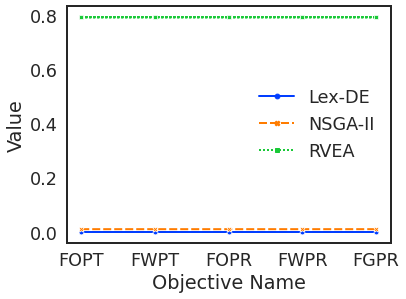

In [10]:
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2, "axes.linewidth": 2})
fig = plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.15, bottom=0.18, right=0.9, top=1)
sns.lineplot(
    data=ts2n_dat_processed_melt,
    x='Objective Name', y='Value',
    hue='Method', style='Method', markers=True,
    estimator=None, units='ID')
ax.set_xticklabels(objective_cod_names)
plt.legend(title='', frameon=False)
plt.savefig('ts2n.parallel.eps')

## Lineplot for the objectives by generations in the runs with best hypervolume

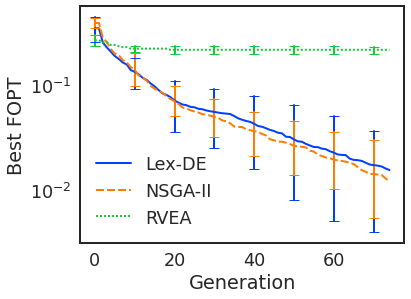

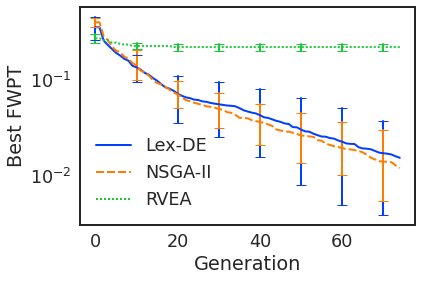

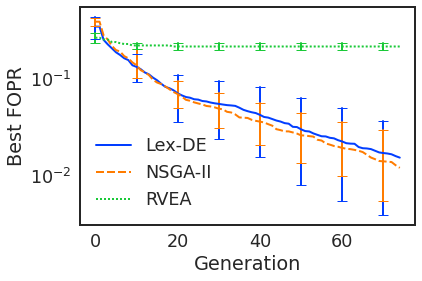

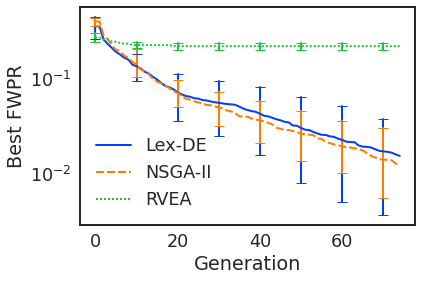

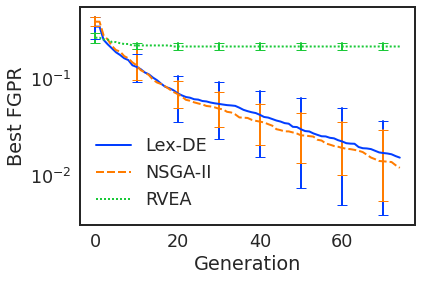

<Figure size 432x288 with 0 Axes>

In [11]:
sns.set_context("paper", font_scale=2., rc={"lines.linewidth": 2, "axes.linewidth": 2})
fig = plt.figure()
ax = fig.add_subplot(111)
plt.subplots_adjust(left=0.2, bottom=0.18, right=0.95, top=1)
for i, objective_sim_name in enumerate(objective_sim_names):
    best_fit_dats = []
    for method_name in method_names:
        for rep in range(len(reps)):
            tmp = utils.best_by_gen(
                ts2n_dat_processed[
                    (ts2n_dat_processed.Method==method_name) & \
                    (ts2n_dat_processed.Repetition==rep)
                ][f'{objective_sim_name}_scaled_by_all'].values,
                fit_name=objective_cod_names[i]
            )
            tmp['Method'] = method_name
            tmp['Repetition'] = rep 
            best_fit_dats.append(tmp)
    best_fit_dats = pd.concat(best_fit_dats).reset_index(drop=True)
    sns.lineplot(data=best_fit_dats,
                 x='Generation', y=f'Best {objective_cod_names[i]}',
                 hue='Method', style='Method',
                 err_style="bars", err_kws={"errorevery": 10,
                                            "capsize": 5})
    plt.yscale('log')
    plt.legend(title='', frameon=False)
    plt.savefig(f'ts2n.{objective_cod_names[i]}.eps')
    plt.show()
    plt.clf()

## Scaled euclidean distance to the ground truth of the non-dominated solutions in the parameter space

In [12]:
ts2n_opt = pd.read_csv('ts2n.opt.dat', header=None)
ts2n_opt.columns = ['Parameter Name', 'Value']
ts2n_opt.index = ts2n_opt['Parameter Name']
ts2n_opt = ts2n_opt.reindex(parameter_names).reset_index(drop=True)
ts2n_opt_scaled = scaler.fit(ts2n_dat[parameter_names].to_numpy()).transform(ts2n_opt.Value.values.reshape(1, -1))
ts2n_opt['Value'] = ts2n_opt_scaled.flatten()
ts2n_opt.head(3)

,Parameter Name,Value
0,POROSITY,0.558376
1,WOC,0.418195
2,COMPRESS,0.498192


In [13]:
dist = lambda df: np.linalg.norm(df, axis=1)
with open('ts2n.dist.csv', 'w') as f:
    print('Method,Repetition,Best Case,Median Case,Worst Case,Average Case', file=f)
for method in tqdm(method_names):
    for rep in range(len(reps)):
        df = ts2n_dat_processed[
            (ts2n_dat_processed.is_nd) & (ts2n_dat_processed.Method==method) & (ts2n_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_all' for item in parameter_names]].values - ts2n_opt.Value.values
        with open('ts2n.dist.csv', 'a') as f:
            print(
                method,
                rep,
                np.min(dist(df)),
                np.median(dist(df)),
                np.max(dist(df)),
                np.mean(dist(df)),
                sep=',',
                file=f
            )

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 61.38it/s]


In [14]:
ts2n_dist = pd.read_csv('ts2n.dist.csv')
ts2n_dist.groupby('Method').aggregate([np.min, np.median, np.max, np.mean, np.std])['Average Case']

,amin,median,amax,mean,std
Method,,,,,
Lex-DE,0.156538,0.338594,0.623325,0.352327,0.169958
NSGA-II,0.256285,0.318746,0.498476,0.358834,0.097707
RVEA,0.683998,0.719160,0.952543,0.793080,0.122536


In [15]:
dist = lambda df: np.linalg.norm(df, axis=1)
with open('ts2n.dist.per.point.csv', 'w') as f:
    print('Method,Repetition,Distance', file=f)
for method in tqdm(method_names):
    for rep in range(len(reps)):
        df = ts2n_dat_processed[
            (ts2n_dat_processed.is_nd) & (ts2n_dat_processed.Method==method) & (ts2n_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_all' for item in parameter_names]].values - ts2n_opt.Value.values
        with open('ts2n.dist.per.point.csv', 'a') as f:
            for d in dist(df):
                print(method, rep, d, sep=',', file=f)

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 64.48it/s]


In [16]:
ts2n_dist_per_point = pd.read_csv('ts2n.dist.per.point.csv')
ts2n_dist_per_point.head(3)

,Method,Repetition,Distance
0,Lex-DE,0,0.350674
1,Lex-DE,1,0.156538
2,Lex-DE,2,0.623325
